# Gesture Recognition

In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

    Group Members:  Saurav Mishra 
                    Debasis Garabadu
                    Sandhita Agarwal
                    Senjuti Kar

In [1]:
import numpy as np
import pandas as pd
import os
from skimage import io
from skimage.transform import resize
import datetime
import glob
import random as rn
import gc

import matplotlib.pyplot as plt
%matplotlib inline

# Ignore Warnings
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf

# Import Keras Packages & API's
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Dropout, BatchNormalization, Activation
from keras.layers.convolutional import Conv2D, MaxPooling3D, Conv3D, MaxPooling2D
from keras.layers import Activation, Dropout, ZeroPadding3D, GlobalAveragePooling2D
from keras.layers.recurrent import LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.optimizers import Adam
from keras.utils import plot_model 
from keras.regularizers import l2
from keras.applications import mobilenet
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras_efficientnets import EfficientNetB0

from keras import backend as K
from keras.backend.tensorflow_backend import set_session
from keras.backend.tensorflow_backend import clear_session
from keras.backend.tensorflow_backend import get_session

Using TensorFlow backend.


We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
rn.seed(30)
tf.set_random_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [3]:
train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('Project_data/val.csv').readlines())
batch_size = 10 #experiment with the batch size

Train Images Shape Check

In [4]:
gestures_path = 'Project_data'

train_df = pd.read_csv('Project_data/train.csv', sep = ';', skipinitialspace = True, header = None)
train_df.columns = ['foldername', 'type', 'value']

train_df

,foldername,type,value
0,WIN_20180925_17_08_43_Pro_Left_Swipe_new,Left_Swipe_new,0
1,WIN_20180925_17_18_28_Pro_Left_Swipe_new,Left_Swipe_new,0
2,WIN_20180925_17_18_56_Pro_Left_Swipe_new,Left_Swipe_new,0
3,WIN_20180925_17_19_51_Pro_Left_Swipe_new,Left_Swipe_new,0
4,WIN_20180925_17_20_14_Pro_Left_Swipe_new,Left_Swipe_new,0
...,...,...,...
658,WIN_20180907_16_38_23_Pro_Thumbs Up_new,Thumbs Up_new,4
659,WIN_20180907_16_41_09_Pro_Thumbs Up_new,Thumbs Up_new,4
660,WIN_20180907_16_42_05_Pro_Thumbs Up_new,Thumbs Up_new,4
661,WIN_20180907_16_42_55_Pro_Thumbs Up_new,Thumbs Up_new,4


In [5]:
# Custom Function to get the unique shape of the images
def get_image_shape(df, path, image_set):
    for data in df['foldername']:
        dirs = gestures_path + path + data
        images = os.listdir(dirs)
    
        for rec in images:
            image_name = dirs + '/' + rec
            image = io.imread(image_name)
            image_set.add(image.shape)
    
    return image_set

In [6]:
# Process to get the size of all the images in the train directory and and create a set just to keep unique values.
image_set = set()
image_set = get_image_shape(train_df, '/train/', image_set)

image_set

{(120, 160, 3), (360, 360, 3)}

Thus the `train` directory has two shape of images `{(360, 360, 3), (120, 160, 3)}`. We need to reshape it to a constant size across all. Before doing that, lets see the shape of images available in `val` directory.

In [7]:
val_df = pd.read_csv('Project_data/val.csv', sep = ';', skipinitialspace = True, header = None)
val_df.columns = ['foldername', 'type', 'value']

val_df

,foldername,type,value
0,WIN_20180925_17_17_04_Pro_Left_Swipe_new,Left_Swipe_new,0
1,WIN_20180925_17_43_01_Pro_Left_Swipe_new,Left_Swipe_new,0
2,WIN_20180925_18_01_40_Pro_Left_Swipe_new,Left_Swipe_new,0
3,WIN_20180925_18_03_21_Pro_Left_Swipe_new,Left_Swipe_new,0
4,WIN_20180926_16_46_22_Pro_Left_Swipe_new,Left_Swipe_new,0
...,...,...,...
95,WIN_20180907_15_43_36_Pro_Thumbs Up_new,Thumbs Up_new,4
96,WIN_20180907_15_52_05_Pro_Thumbs Up_new,Thumbs Up_new,4
97,WIN_20180907_15_54_30_Pro_Thumbs Up_new,Thumbs Up_new,4
98,WIN_20180907_16_10_59_Pro_Thumbs Up_new,Thumbs Up_new,4


In [8]:
# Process to get the size of all the images in the val directory and and create a set just to keep unique values.
image_set = set()
image_set = get_image_shape(val_df, '/val/', image_set)

image_set

{(120, 160, 3), (360, 360, 3)}

Thus both Train and Val dataset has same shape of images `{(360, 360, 3), (120, 160, 3)}`. To keep it constant across all, we can reshape the image to `(120, 120, 3)`

For images with dimension `(360, 360, 3)`, we will resize to dimension `(120, 120, 3)` and for images with dimension `(120, 160, 3)`, we will crop the image to make it to dimension `(120, 120, 3)`.

<br></br>
Lets see some random selected images with reshape and crop method.

In [9]:
# Custom Function to resize or cropt the image to (120, 120, 3)
def image_resize_crop(image_type, sample_image_name):
    print(image_type)
    print('********************************************************')
    
    sample_image = io.imread(sample_image_name)
    print('\nOriginal Shape =', sample_image.shape)

    if sample_image.shape[0] == 120:
        # Image Crop
        new_image = sample_image[0:120, 0:120]
        print('\nNew Shape =', new_image.shape)
    
    elif sample_image.shape[0] == 360:
        # Image Resize
        new_image = resize(sample_image, (120, 120))
        print('\nNew Shape =', new_image.shape)

    f, axes = plt.subplots(1, 5)
    f.set_figwidth(20)

    # Original Image
    axes[0].imshow(sample_image)
    # New Cropped/Resize Image
    axes[1].imshow(new_image)
    # RGB channels of the new image
    axes[2].imshow(new_image[:, : , 0])
    axes[3].imshow(new_image[:, : , 1])
    axes[4].imshow(new_image[:, : , 2])
    f.suptitle('Original to Transformed Image and its different channels')
    plt.show()

Left Swipe Cropping from (120, 160, 3) to (120, 120, 3)
********************************************************

Original Shape = (120, 160, 3)

New Shape = (120, 120, 3)


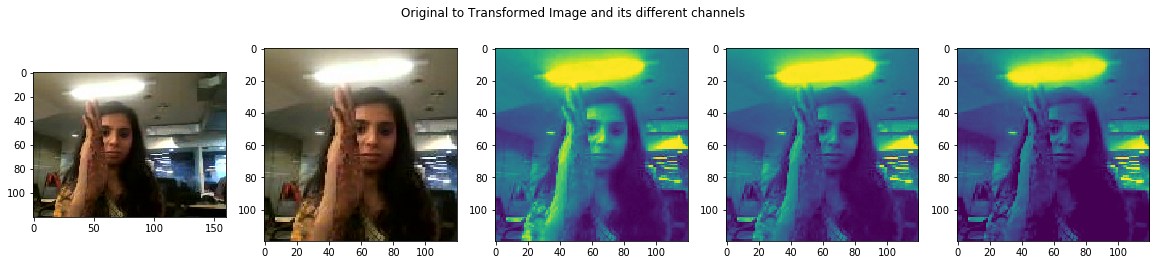

In [10]:
# Crop image (120, 160, 3) to (120, 120, 3)
image_type = 'Left Swipe Cropping from (120, 160, 3) to (120, 120, 3)'
sample_image_name = 'Project_data/train/WIN_20180925_17_33_08_Pro_Left_Swipe_new/WIN_20180925_17_33_08_Pro_00014.png'

image_resize_crop(image_type, sample_image_name)

Left Swipe Resize from (360, 360, 3) to (120, 120, 3)
********************************************************

Original Shape = (360, 360, 3)

New Shape = (120, 120, 3)


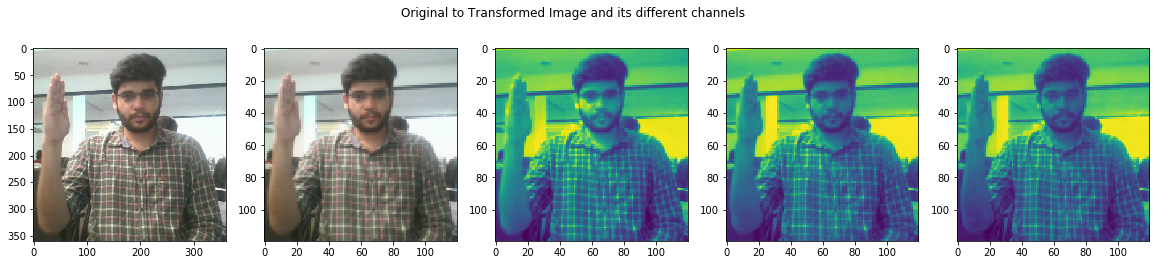

In [11]:
# Resize image (360, 360, 3) to (120, 120, 3)
image_type = 'Left Swipe Resize from (360, 360, 3) to (120, 120, 3)'
sample_image_name = 'Project_data/train/WIN_20180907_15_45_40_Pro_Left Swipe_new_Left Swipe_new/WIN_20180907_15_45_40_Pro_00029.png'

image_resize_crop(image_type, sample_image_name)

Right Swipe Cropping from (120, 160, 3) t (120, 120, 3)
********************************************************

Original Shape = (120, 160, 3)

New Shape = (120, 120, 3)


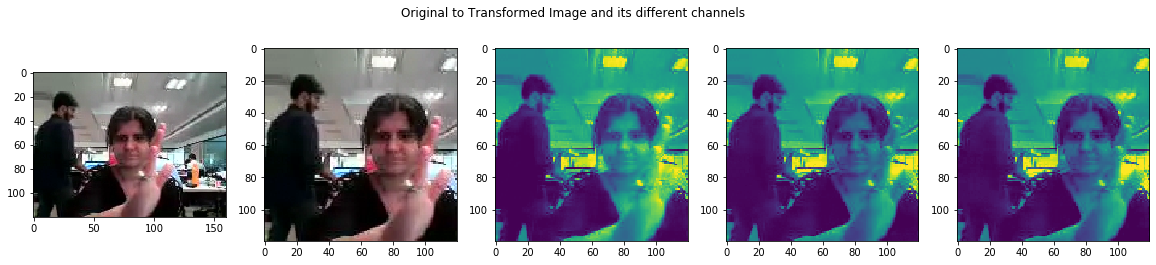

In [12]:
# Crop image (120, 160, 3) to (120, 120, 3)
image_type = 'Right Swipe Cropping from (120, 160, 3) t (120, 120, 3)'
sample_image_name = 'Project_data/train/WIN_20180926_17_05_54_Pro_Right_Swipe_new/WIN_20180926_17_05_54_Pro_00036.png'

image_resize_crop(image_type, sample_image_name)

Right Swipe Resize from (360, 360, 3) to (120, 120, 3)
********************************************************

Original Shape = (360, 360, 3)

New Shape = (120, 120, 3)


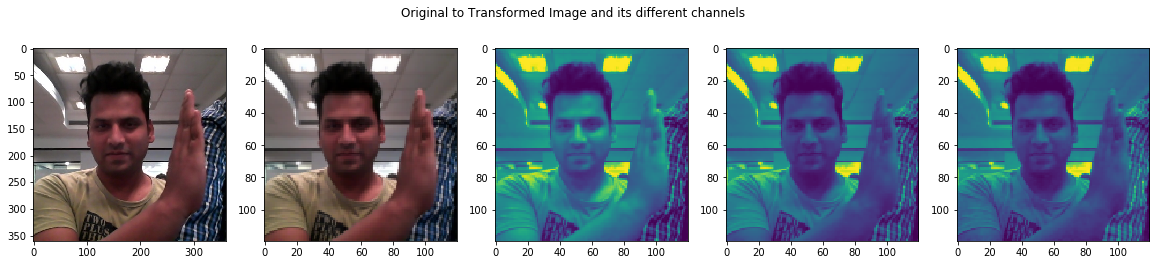

In [13]:
# Resize image (360, 360, 3) to (120, 120, 3)
image_type = 'Right Swipe Resize from (360, 360, 3) to (120, 120, 3)'
sample_image_name = 'Project_data/train/WIN_20180907_15_51_58_Pro_Right Swipe_new/WIN_20180907_15_51_58_Pro_00021.png'

image_resize_crop(image_type, sample_image_name)

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [14]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    
    #create a list of image numbers you want to use for a particular video
    img_idx = [k for k in range(0, 30)]
    x = 30
    y = 120
    z = 120
    
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t)//batch_size # calculate the number of batches
        
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = io.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    #As performed in the sample image, we will crop the image to (120, 120, 3), if the shape is (120, 160, 3)
                    #and we will resize to (120, 120, 3), if the shape is (360, 360, 3)
                    if image.shape[0] == 120:
                        # Image Crop
                        image = image[0:120, 0:120]
                    elif image.shape[0] == 360:
                        # Image Resize
                        image = resize(image, (120, 120))
                    
                    batch_data[folder,idx,:,:,0] = image[:, :, 0]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image[:, :, 1]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:, :, 2]/255 #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
        
        # write the code for the remaining data points which are left after full batches
        remaining_data_points = len(t) - (num_batches * batch_size) # calculate the number of remaining data points
        if remaining_data_points > 0:
            batch_data = np.zeros((remaining_data_points,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((remaining_data_points,5)) # batch_labels is the one hot representation of the output
            for folder in range(remaining_data_points): # iterate over the remaining_data_points
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = io.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    #As performed in the sample image, we will crop the image to (120, 120, 3), if the shape is (120, 160, 3)
                    #and we will resize to (120, 120, 3), if the shape is (360, 360, 3)
                    if image.shape[0] == 120:
                        # Image Crop
                        image = image[0:120, 0:120]
                    elif image.shape[0] == 360:
                        # Image Resize
                        image = resize(image, (120, 120))
                    
                    batch_data[folder,idx,:,:,0] = image[:, :, 0]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image[:, :, 1]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:, :, 2]/255 #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [15]:
# Initialize the model train parameters

curr_dt_time = datetime.datetime.now()

train_path = 'Project_data/train'
val_path = 'Project_data/val'

num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)

num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

num_epochs = 40 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 40


## Model Builder
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

We will create a class containing all our models. These models are defined in respective methods. 
All the methods are static and will not need a class instance to be created.
<br></br>
<br></br>
Each model takes in the **input_shape** and the **nb_classes** (total output classes) as parameters.

In [16]:
# write your model here

class ModelBuilder(object):
    
    ###############################################
    #  Conv2D + RNN - Time Distributed Model - 1  #
    #           5 Convolutional Layers            #
    ###############################################
    @staticmethod
    def conv2d_rnn_time_distributed_1(input_shape, nb_classes, dropout = 0.50):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3), strides=(2, 2), activation='relu', padding='same'), input_shape=input_shape))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        

        model.add(TimeDistributed(Conv2D(32, (3,3), padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        

        model.add(TimeDistributed(Conv2D(64, (3,3), padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        

        model.add(TimeDistributed(Conv2D(128, (3,3), padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
       
        model.add(TimeDistributed(Flatten()))
        

        model.add(LSTM(256, return_sequences=False))
        model.add(Dropout(dropout))

        model.add(Dense(nb_classes, activation='softmax'))
        
        return model
    
    
    ###############################################
    #  Conv2D + RNN - Time Distributed Model - 2  #
    #           6 Convolutional Layers            #
    ###############################################
    @staticmethod
    def conv2d_rnn_time_distributed_2(input_shape, nb_classes, dropout = 0.50):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3), strides=(2, 2), activation='relu', padding='same'), input_shape=input_shape))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        

        model.add(TimeDistributed(Conv2D(32, (3,3), padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        

        model.add(TimeDistributed(Conv2D(64, (3,3), padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        

        model.add(TimeDistributed(Conv2D(128, (3,3), padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        
        model.add(TimeDistributed(Conv2D(256, (3,3), padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        

        model.add(TimeDistributed(Flatten()))
        

        model.add(LSTM(256, return_sequences=False))
        model.add(Dropout(dropout))

        model.add(Dense(nb_classes, activation='softmax'))
        
        return model
    
    
    ###############################################
    #  Conv2D + RNN - LSTM - GRU                  #
    ###############################################
    @staticmethod
    def conv2d_rnn_time_distributed_GRU(input_shape, nb_classes, dropout = 0.50):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3), strides=(2, 2), activation='relu', padding='same'), input_shape=input_shape))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        

        model.add(TimeDistributed(Conv2D(32, (3,3), padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        

        model.add(TimeDistributed(Conv2D(64, (3,3), padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        

        model.add(TimeDistributed(Conv2D(128, (3,3), padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        
        model.add(TimeDistributed(Conv2D(256, (3,3), padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Flatten()))
        
        # add the GRU layer
        model.add(GRU(256, return_sequences=False))
        model.add(Dropout(dropout))
        
        model.add(Dense(256,activation='relu'))
        model.add(Dropout(dropout))

        model.add(Dense(nb_classes, activation='softmax'))
        
        return model
    
    
    # Convolution 3D Models - Conv3D and MaxPooling3D 

    ###############################################
    # Conv3D - MaxPooling3D - Model - 1           #
    # 4 Colvolutional layers                      #
    ###############################################
    @staticmethod
    def conv3d_model_1(input_shape, nb_classes, dropout = 0.25):

        model = Sequential()
        
        model.add(Conv3D(16, (3,3,3), padding='same',input_shape = input_shape))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (3,3,3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (3,3,3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (3,3,3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(128, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(nb_classes,activation='softmax'))

        return model
    
    ###############################################
    #  Conv3D - MaxPooling3D - Model - 2          #
    #  Adding a new convolutional layer           #
    ###############################################
    @staticmethod
    def conv3d_model_2(input_shape, nb_classes, dropout = 0.50):
        
        model = Sequential()
        
        model.add(Conv3D(16, (3,3,3), input_shape = input_shape, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (3,3,3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (3,3,3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (3,3,3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        # the additional convolutional layer
        model.add(Conv3D(256, (3,3,3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        # model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(256,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(128,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(nb_classes,activation='softmax'))
        
        return model
    
    ###############################################
    #  Conv3D - MaxPooling3D - Model - 3          #
    #  Adding a new convolutional layer           #
    ###############################################
    @staticmethod
    def conv3d_model_3(input_shape, nb_classes, dropout = 0.50):
        
        model = Sequential()
        
        model.add(Conv3D(16, (3,3,3), padding='same',input_shape = input_shape))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, (3,3,3), padding='same',input_shape = input_shape))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (3,3,3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, (3,3,3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (3,3,3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, (3,3,3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (3,3,3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, (3,3,3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(64, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(64, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(nb_classes, activation='softmax'))
        
        return model
    
    ###############################################
    #  Conv3D - MaxPooling3D - Model - 4          #
    #  Adding dropouts at convolutional layer     #
    ###############################################
    @staticmethod
    def conv3d_model_4(input_shape, nb_classes, dropout = 0.50):
        
        model = Sequential()
        
        model.add(Conv3D(16, (3,3,3), padding='same', input_shape = input_shape))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout)) # adding the dropout layer at each convolution layer

        model.add(Conv3D(32, (3,3,3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout)) # adding the dropout layer at each convolution layer

        model.add(Conv3D(64, (3,3,3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout)) # adding the dropout layer at each convolution layer

        model.add(Conv3D(128, (3,3,3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout)) # adding the dropout layer at each convolution layer
        
        model.add(Flatten())
        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(nb_classes, activation='softmax'))
        
        return model
    
    ###############################################
    #  Conv3D - MaxPooling3D - Model - 5          #
    #  Adding L2 regularizer - kernel_regularizer #
    ###############################################
    @staticmethod
    def conv3d_l2_regularizer_model_5(input_shape, nb_classes, filtersize = (3,3,3), dropout = 0.50):
        
        model = Sequential()
        
        model.add(Conv3D(16, filtersize, padding='same', input_shape = input_shape))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(64,activation='relu', kernel_regularizer=l2(0.01)))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(nb_classes, activation='softmax'))
        
        return model

    
    ###############################################
    # Conv3D - MaxPooling3D - Model - 6           #
    # Adding L2 regularizer                       #
    # Adding more layers with l2 regularization   #
    ###############################################
    @staticmethod
    def conv3d_l2_regularizer_model_6(input_shape, nb_classes, filtersize = (3,3,3), dropout = 0.50):
        
        model = Sequential()
        
        model.add(Conv3D(16, filtersize, padding='same', input_shape = input_shape))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        
        model.add(Flatten())
        model.add(Dense(64,activation='relu', kernel_regularizer=l2(0.01)))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(nb_classes, activation='softmax'))
        
        return model
    
    
    ########################################################
    #  Conv3D - MaxPooling3D - Model - 7                   #
    #  Adding L2 Regularizer                               #
    #  Modifying the flatten layer output space dimension  #
    ########################################################
    @staticmethod
    def conv3d_l2_regularizer_model_7(input_shape, nb_classes, filtersize = (3,3,3), dropout = 0.50):
        
        model = Sequential()
        
        model.add(Conv3D(16, filtersize, padding='same', input_shape = input_shape))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(256,activation='relu', kernel_regularizer=l2(0.01)))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(128,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(nb_classes, activation='softmax'))
        
        return model
    
    
    ###############################################
    # Conv3D - MaxPooling3D - Model - 8           #
    # Adding L2 regularizer                       #
    # Adding more layers with l2 regularization   #
    ###############################################
    @staticmethod
    def conv3d_l2_regularizer_model_8(input_shape, nb_classes, filtersize = (3,3,3), dropout = 0.50):
        
        model = Sequential()
        
        model.add(Conv3D(16, filtersize, padding='same', input_shape = input_shape))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))
        
        model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(nb_classes, activation='softmax'))
        
        return model
    
    
    ###############################################
    # Transfer Learning Model using Imagenet      #
    # wih LSTM                                    #
    ###############################################
    
    @staticmethod
    def ImageNet_Transfer_Learn_Model_LSTM(input_shape, nb_classes, lstm_cells = 64, dense_neurons = 64, dropout = 0.25):
        
        mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer, input_shape = input_shape))

        for layer in model.layers:
            layer.trainable = False

        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons, activation='relu'))
        model.add(Dropout(dropout))

        model.add(Dense(nb_classes, activation='softmax'))

        return model
    
    
    ###############################################
    # Transfer Learning Model using Imagenet      #
    # with GRU with trainable layers              #
    ###############################################
    @staticmethod
    def ImageNet_Transfer_Learn_Model_GRU(input_shape, nb_classes, gru_cells=64, dense_neurons=64, dropout=0.25):
        
        mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)
        
        model = Sequential()
        
        model.add(TimeDistributed(mobilenet_transfer, input_shape = input_shape))
        
#         for layer in model.layers:
#             layer.trainable = False
 
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(GRU(gru_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons, activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(nb_classes, activation='softmax'))
        
        return model
    
    
    #################################################
    # Transfer Learning Model using                 #
    # InceptionResNetV2 wih GRU                     #
    # We will train the layers of InceptionResNetV2 #
    # models as well.                               #
    #################################################
    @staticmethod
    def InceptionResNetV2_Transfer_Learn_Model(input_shape, nb_classes):
        
        # create the base pre-trained model
        base_model = InceptionResNetV2(include_top=False, weights='imagenet', input_shape=input_shape)

        # freeze all convolutional InceptionResNetV2 layers
        #for layer in base_model.layers:
            #layer.trainable = False

        # add a global spatial average pooling layer
        x = base_model.output
        x = GlobalAveragePooling2D()(x)

        # create the fine tuned base model
        base_model = Model(inputs=base_model.input, outputs=x)

        # this is the model we will train
        model = Sequential()

        # Add the base model on top of the final model
        model.add(TimeDistributed(base_model, input_shape=base_model.input_shape))
        model.add(TimeDistributed(Flatten(input_shape=base_model.input_shape[1:])))

        # LSTM
        model.add(GRU(256, activation='relu', dropout=0.5))

        # output layer
        model.add(Dense(nb_classes, activation = 'softmax'))
        
        return model
    
    ###############################################
    # Transfer Learning Model using               #
    # EfficientNetB0 wih GRU                      #
    # We will train the layers of EfficientNetB0  #
    # models as well.                             #
    ###############################################
    @staticmethod
    def EfficientNetB0_Transfer_Learn_Model(input_shape, nb_classes):
    
        # create the base pre-trained model
        base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=input_shape)

        # freeze all convolutional layers
        #for layer in base_model.layers:
            #layer.trainable = False

        # add a global spatial average pooling layer
        x = base_model.output
        x = GlobalAveragePooling2D()(x)

        # create the fine tuned base model
        base_model = Model(inputs=base_model.input, outputs=x)

        # this is the model we will train
        model = Sequential()

        # Add the base model on top of the final model
        model.add(TimeDistributed(base_model, input_shape=base_model.input_shape))
        model.add(TimeDistributed(Flatten(input_shape=base_model.input_shape[1:])))

        # GRU
        model.add(GRU(256, activation='relu', dropout=0.5))

        # output layer
        model.add(Dense(nb_classes, activation = 'softmax'))
        
        return model
    

## ModelTrainer

A class whose purpose is to **initialize**, **train** and **plot** (the accuracy & the loss) for the model's train and validation history.

In [17]:
class ModelTrainer:
    
    ###############################################
    # Method to initialize the model train params #
    ###############################################
    @staticmethod
    def InitializeModelParams():
        
        # Model train parameters
        num_train_sequences = len(train_doc)
        print('# training sequences =', num_train_sequences)
        
        num_val_sequences = len(val_doc)
        print('# validation sequences =', num_val_sequences)
        
        print('# batch size =', batch_size)    
        print('# epochs =', num_epochs)
        
        
        
    ##########################################################################
    # Model Train                                                            #
    ##########################################################################
    @staticmethod
    def train(model, batch_size, num_epochs, train_generator, val_generator, optimiser = None):

         # Initialize the model optimizer
        if optimiser == None:
            optimiser = Adam()

        # compile the model. When you print the summary of the model, 
        # you'll see the total number of parameters you have to train.
        model.compile(optimizer = optimiser, loss = 'categorical_crossentropy', metrics = ['categorical_accuracy'])
        print (model.summary())
        
        curr_dt_time = datetime.datetime.now()
        model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

        if not os.path.exists(model_name):
            os.mkdir(model_name)

        #filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        filepath = model_name + 'final_model.h5'
        
        # generate the model checkpoint.
        checkpoint = ModelCheckpoint(filepath, 
                                     monitor = 'val_loss', 
                                     verbose = 1, 
                                     save_best_only = True, 
                                     save_weights_only = False, 
                                     mode = 'auto', 
                                     period = 1)
        
        LR = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, patience = 2, cooldown = 1, verbose = 1)
        ES = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
        callbacks_list = [checkpoint, ES, LR]

        # initialize the train parameters - The steps_per_epoch and validation_steps are used by 
        # fit_generator to decide the number of next() calls it need to make.
        if (num_train_sequences%batch_size) == 0:
            steps_per_epoch = int(num_train_sequences/batch_size)
        else:
            steps_per_epoch = (num_train_sequences//batch_size) + 1

        if (num_val_sequences%batch_size) == 0:
            validation_steps = int(num_val_sequences/batch_size)
        else:
            validation_steps = (num_val_sequences//batch_size) + 1


        # fit the model - This will start training the model and with the help of the checkpoints, 
        # you'll be able to save the model at the end of each epoch.
        model_history = model.fit_generator(train_generator, steps_per_epoch = steps_per_epoch, epochs = num_epochs, verbose = 1, 
                    callbacks = callbacks_list, validation_data = val_generator, 
                    validation_steps = validation_steps, class_weight = None, workers = 1, initial_epoch = 0)


        return model_history
    
    
    
    ##########################################################################
    # This method takes the model train history as parameter and plots the   #
    # Loss & Accuracy curves for the train and validation data.              #
    ##########################################################################
    @staticmethod
    def plot_model_history(history):
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
        axes[0].plot(history.history['loss'])   
        axes[0].plot(history.history['val_loss'])
        axes[0].legend(['loss','val_loss'])

        axes[1].plot(history.history['categorical_accuracy'])   
        axes[1].plot(history.history['val_categorical_accuracy'])
        axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])
    
    
    
    ##########################################################################
    # clear_previous_keras_session - This method clears the previous         #
    # keras training session from the backend & prepares for the next        #
    # train session.                                                         #
    # Useful to avoid clutter from old models / layers.                      #
    ##########################################################################
    @staticmethod
    def clear_previous_keras_session():
        sess = get_session()
        clear_session()
        sess.close()
        sess = get_session()

        try:
            del base_model, model # this is from global space - change this as you need
        except:
            pass

        K.clear_session()

        gc.collect()
        print("Previous Keras Session Cleared...")

        # use the same config as you used to create the session
        config = tf.ConfigProto()
        config.gpu_options.per_process_gpu_memory_fraction = 1
        config.gpu_options.visible_device_list = "0"
        set_session(tf.Session(config=config))
        
    

In [18]:
train_path = 'Project_data/train'
val_path = 'Project_data/val'
input_shape = (30, 120, 120, 3)
nb_classes = 5

# generate the train and validation data
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

## Model 1
### Conv2D + RNN - Time Distributed Model 1 with LSTM - 5 Convolutional Layers  

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 30, 60, 60, 16)    448       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 30, 60, 60, 16)    64        
_________________________________________________________________
time_distributed_3 (TimeDist (None, 30, 30, 30, 16)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 30, 30, 30, 32)    4640      
_________________________________________________________________
time_distributed_5 (TimeDist (None, 30, 30, 30, 32)    128       
_________________________________________________________________
time_distributed_6 (TimeDist (None, 30, 15, 15, 32)    0         
_________________________________________________________________
time_distributed_7 (TimeDist (None, 30, 15, 15, 64)    18496     
__________


Epoch 00022: val_loss did not improve from 0.76471
Epoch 23/40
67/67 [==============================] - 86s 1s/step - loss: 0.0575 - categorical_accuracy: 0.9940 - val_loss: 0.8916 - val_categorical_accuracy: 0.6800

Epoch 00023: val_loss did not improve from 0.76471

Epoch 00023: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.
Epoch 24/40
67/67 [==============================] - 84s 1s/step - loss: 0.0420 - categorical_accuracy: 0.9985 - val_loss: 0.8889 - val_categorical_accuracy: 0.6900

Epoch 00024: val_loss did not improve from 0.76471
Epoch 25/40
67/67 [==============================] - 82s 1s/step - loss: 0.0457 - categorical_accuracy: 0.9970 - val_loss: 0.8897 - val_categorical_accuracy: 0.6900

Epoch 00025: val_loss did not improve from 0.76471

Epoch 00025: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.
Epoch 26/40
67/67 [==============================] - 85s 1s/step - loss: 0.0513 - categorical_accuracy: 0.9955 - val_loss: 0.8905 - val

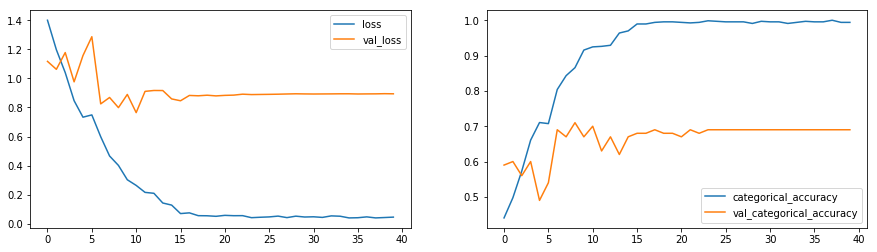

In [22]:
# build the model
time_distributed_conv2d_rnn = ModelBuilder.conv2d_rnn_time_distributed_1(input_shape, nb_classes)

# train the model
time_distributed_conv2d_rnn_history = ModelTrainer.train(time_distributed_conv2d_rnn, batch_size, num_epochs, 
                                                         train_generator, val_generator)

# plot the model train and validation history - loss and accuracy curves
ModelTrainer.plot_model_history(time_distributed_conv2d_rnn_history)

### Inference - 
#### We got the best validation accuracy as 70% when training accuracy is 92.54%. The result is not satisfactory. Thus, Model 1 is not able to learn much from the training data.

#### Lets try with a different variant for Conv2D + RNN.

## Model 2 
### Conv2D + RNN - Time Distributed Model 2 with LSTM - 6 Convolutional Layers

Previous Keras Session Cleared...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 30, 60, 60, 16)    448       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 30, 60, 60, 16)    64        
_________________________________________________________________
time_distributed_3 (TimeDist (None, 30, 30, 30, 16)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 30, 30, 30, 32)    4640      
_________________________________________________________________
time_distributed_5 (TimeDist (None, 30, 30, 30, 32)    128       
_________________________________________________________________
time_distributed_6 (TimeDist (None, 30, 15, 15, 32)    0         
_________________________________________________________________
time_distributed_7 (TimeDist (None, 30, 15


Epoch 00021: val_loss did not improve from 0.62692
Epoch 22/40
67/67 [==============================] - 86s 1s/step - loss: 0.0235 - categorical_accuracy: 0.9955 - val_loss: 0.8985 - val_categorical_accuracy: 0.7500

Epoch 00022: val_loss did not improve from 0.62692

Epoch 00022: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.
Epoch 23/40
67/67 [==============================] - 83s 1s/step - loss: 0.0243 - categorical_accuracy: 0.9955 - val_loss: 0.7769 - val_categorical_accuracy: 0.7800

Epoch 00023: val_loss did not improve from 0.62692
Epoch 24/40
67/67 [==============================] - 87s 1s/step - loss: 0.0189 - categorical_accuracy: 0.9985 - val_loss: 0.9549 - val_categorical_accuracy: 0.7400

Epoch 00024: val_loss did not improve from 0.62692

Epoch 00024: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.
Epoch 25/40
67/67 [==============================] - 84s 1s/step - loss: 0.0191 - categorical_accuracy: 0.9970 - val_loss: 0.7516 - val

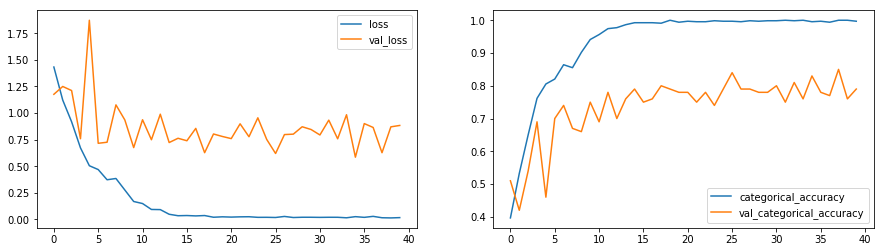

In [23]:
# clear the previous session before poceeding with the new model.
ModelTrainer.clear_previous_keras_session()

# build the model
time_distributed_conv2d_rnn_2 = ModelBuilder.conv2d_rnn_time_distributed_2(input_shape, nb_classes)

# train the model
model_history_2 = ModelTrainer.train(time_distributed_conv2d_rnn_2, batch_size, num_epochs, train_generator, val_generator)

# plot the model train and validation history - loss and accuracy curves
ModelTrainer.plot_model_history(model_history_2)

### Inference - 
#### We got validation accuracy as 83% when training accuracy is 99.55%, which is a good model in terms of CNN (CONV2D) + RNN. Thus, Model 2 is able to learn better than the model 1 in terms of capturing information from the training data.

#### Now keeping this accuracy score as the bench mark let's see if we can improve this further.

## Model 3
### Conv2D + RNN - Time Distributed Model with GRU units

Previous Keras Session Cleared...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 30, 60, 60, 16)    448       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 30, 60, 60, 16)    64        
_________________________________________________________________
time_distributed_3 (TimeDist (None, 30, 30, 30, 16)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 30, 30, 30, 32)    4640      
_________________________________________________________________
time_distributed_5 (TimeDist (None, 30, 30, 30, 32)    128       
_________________________________________________________________
time_distributed_6 (TimeDist (None, 30, 15, 15, 32)    0         
_________________________________________________________________
time_distributed_7 (TimeDist (None, 30, 15

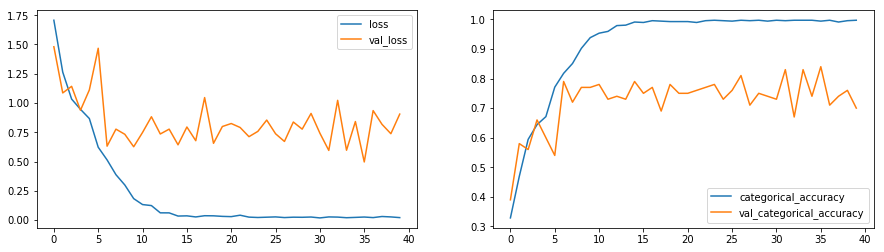

In [24]:
# clear the previous session before poceeding with the new model.
ModelTrainer.clear_previous_keras_session()

# build the model
time_distributed_conv2d_gru = ModelBuilder.conv2d_rnn_time_distributed_GRU(input_shape, nb_classes)

# train the model
model_history_gru = ModelTrainer.train(time_distributed_conv2d_gru, batch_size, num_epochs, train_generator, val_generator)

# plot the model train and validation history - loss and accuracy curves
ModelTrainer.plot_model_history(model_history_gru)

### Inference - 
#### We got the validation accuracy as 84% when training accuracy is 99.4%. This is a slight improvement from model 2 and is a very good score in terms of CNN (CONV2D) + RNN. 

#### Thus, Model 3 is able to learn and capture the information better that the previous model.

### <font color='red'>The link to the .h5 file for the final model is provided at the end in the summary section.</font>

#### Let's try to improve further.

## Model 4
### Conv3D - MaxPooling3D - Model 1 with 4 Convolutional Layers 

Previous Keras Session Cleared...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 30, 120, 120, 16)  1312      
_________________________________________________________________
activation_1 (Activation)    (None, 30, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 15, 60, 60, 16)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 15, 60, 60, 32)    13856     
_________________________________________________________________
activation_2 (Activation)    (None, 15, 60, 60, 32)    0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 15, 60

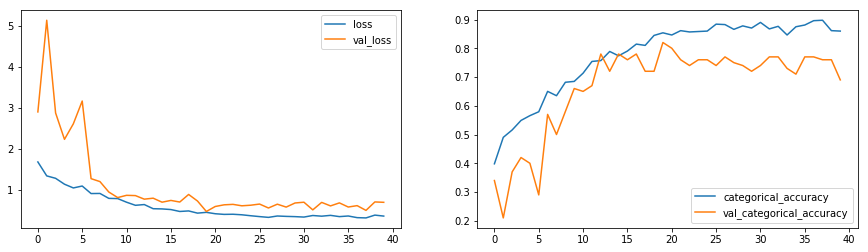

In [25]:
# clear the previous session before poceeding with the new model.
ModelTrainer.clear_previous_keras_session()

# build the model
conv3d_1 = ModelBuilder.conv3d_model_1(input_shape, nb_classes)

# train the model
model_history_conv3d_1 = ModelTrainer.train(conv3d_1, batch_size, num_epochs, train_generator, val_generator)

# plot the model train and validation history - loss and accuracy curves
ModelTrainer.plot_model_history(model_history_conv3d_1)

### Inference - 
#### Validation Accuracy is 82% when Training Accuracy is 84.77%. As compared to the models 2 & 3 there is a slight drop in the learning capability of this model. This is not as good when compared to the current benchmark scores of Model 2 or 3.

#### Let's now see with the 2nd variant of Convulation 3D Model.

## Model 5
### Conv3D - MaxPooling3D - Model 2 with 5 Convolutional Layers

Previous Keras Session Cleared...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 30, 120, 120, 16)  1312      
_________________________________________________________________
activation_1 (Activation)    (None, 30, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 15, 60, 60, 16)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 15, 60, 60, 32)    13856     
_________________________________________________________________
activation_2 (Activation)    (None, 15, 60, 60, 32)    0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 15, 60

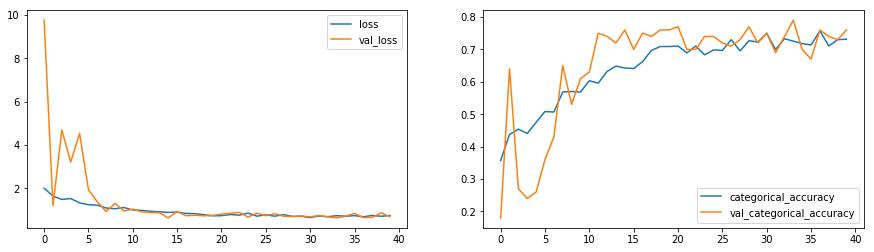

In [26]:
# clear the previous session before poceeding with the new model.
ModelTrainer.clear_previous_keras_session()

# build the model
conv3d_2 = ModelBuilder.conv3d_model_2(input_shape, nb_classes)

# train the model
model_history_conv3d_2 = ModelTrainer.train(conv3d_2, batch_size, num_epochs, train_generator, val_generator)

# plot the model train and validation history - loss and accuracy curves
ModelTrainer.plot_model_history(model_history_conv3d_2)

### Inference - 

#### We got a Validation Accuracy of 76%. This is not a good model comparing the accuracy we reached with our previous models. This is not acceptable.

#### Let's try to create a different variant by makng the model deeper by adding more convolution layers.

## Model 6

### Adding more convolution layers to make the model deeper.

Previous Keras Session Cleared...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 30, 120, 120, 16)  1312      
_________________________________________________________________
activation_1 (Activation)    (None, 30, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 120, 120, 16)  64        
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 30, 120, 120, 16)  6928      
_________________________________________________________________
activation_2 (Activation)    (None, 30, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 30, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 15, 60

67/67 [==============================] - 103s 2s/step - loss: 1.4124 - categorical_accuracy: 0.4666 - val_loss: 1.2417 - val_categorical_accuracy: 0.4800

Epoch 00013: val_loss did not improve from 1.09574

Epoch 00013: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
Epoch 14/40
67/67 [==============================] - 102s 2s/step - loss: 1.3135 - categorical_accuracy: 0.4871 - val_loss: 1.2547 - val_categorical_accuracy: 0.4900

Epoch 00014: val_loss did not improve from 1.09574
Epoch 15/40
67/67 [==============================] - 102s 2s/step - loss: 1.2839 - categorical_accuracy: 0.4860 - val_loss: 1.2933 - val_categorical_accuracy: 0.4500

Epoch 00015: val_loss did not improve from 1.09574

Epoch 00015: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
Epoch 16/40
67/67 [==============================] - 102s 2s/step - loss: 1.2931 - categorical_accuracy: 0.5059 - val_loss: 1.1132 - val_categorical_accuracy: 0.5100

Epoch 00016: val_loss did no

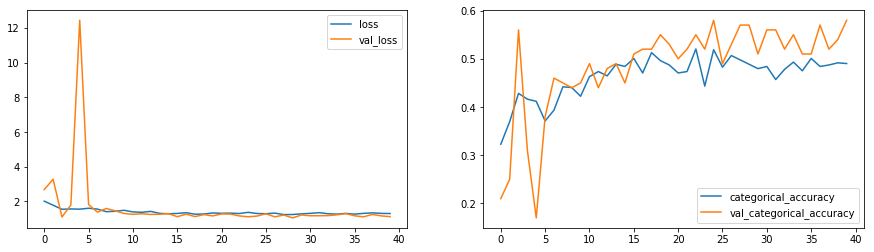

In [20]:
# clear the previous session before poceeding with the new model.
ModelTrainer.clear_previous_keras_session()

# build the model
conv3d_3 = ModelBuilder.conv3d_model_3(input_shape, nb_classes)

# train the model
model_history_conv3d_3 = ModelTrainer.train(conv3d_3, batch_size, num_epochs, train_generator, val_generator)

# plot the model train and validation history - loss and accuracy curves
ModelTrainer.plot_model_history(model_history_conv3d_3)

### Inference - 

#### The model returns Validation Accuracy of just 57% which is very low compared to the benchmark scores. This model is not acceptable.

#### Let's now create a model by adding Dropout layers after each convolution layers.

## Model 7

### Adding dropout layer after each convolution layer.

Previous Keras Session Cleared...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 30, 120, 120, 16)  1312      
_________________________________________________________________
activation_1 (Activation)    (None, 30, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 15, 60, 60, 16)    0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 60, 60, 16)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 15, 60, 60, 32)    13856     
_________________________________________________________________
activation_2 (Activation)    (None, 15, 60

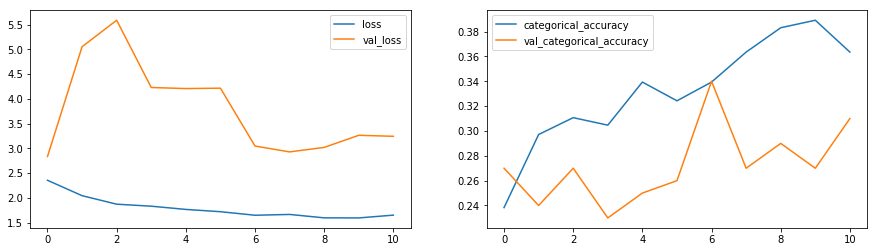

In [22]:
# clear the previous session before poceeding with the new model.
ModelTrainer.clear_previous_keras_session()

# build the model
conv3d_4 = ModelBuilder.conv3d_model_4(input_shape, nb_classes)

# train the model
model_history_conv3d_4 = ModelTrainer.train(conv3d_4, batch_size, num_epochs, train_generator, val_generator)

# plot the model train and validation history - loss and accuracy curves
ModelTrainer.plot_model_history(model_history_conv3d_4)

### Inference - 

#### We got a Validation Accuracy as a mere 24%. Also as the loss did not decrease for 10 consecutive epochs, the model stopped training after the 11 epoch due to the EarlyStopping callback implemented.

#### Let's try to add a L2 regularizer to the model

## Model 8

### Adding L2 regularizer

Previous Keras Session Cleared...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 30, 120, 120, 16)  1312      
_________________________________________________________________
activation_1 (Activation)    (None, 30, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 15, 60, 60, 16)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 15, 60, 60, 32)    13856     
_________________________________________________________________
activation_2 (Activation)    (None, 15, 60, 60, 32)    0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 15, 60

67/67 [==============================] - 84s 1s/step - loss: 1.6652 - categorical_accuracy: 0.5980 - val_loss: 1.4825 - val_categorical_accuracy: 0.7200

Epoch 00018: val_loss improved from 1.56426 to 1.48252, saving model to model_init_2019-09-1703_56_21.067466/final_model.h5
Epoch 19/40
67/67 [==============================] - 85s 1s/step - loss: 1.7641 - categorical_accuracy: 0.5602 - val_loss: 1.6057 - val_categorical_accuracy: 0.5600

Epoch 00019: val_loss did not improve from 1.48252
Epoch 20/40
67/67 [==============================] - 88s 1s/step - loss: 1.7082 - categorical_accuracy: 0.5681 - val_loss: 1.5177 - val_categorical_accuracy: 0.6600

Epoch 00020: val_loss did not improve from 1.48252

Epoch 00020: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Epoch 21/40
67/67 [==============================] - 84s 1s/step - loss: 1.6436 - categorical_accuracy: 0.6204 - val_loss: 1.4173 - val_categorical_accuracy: 0.7200

Epoch 00021: val_loss improved from 1.4825

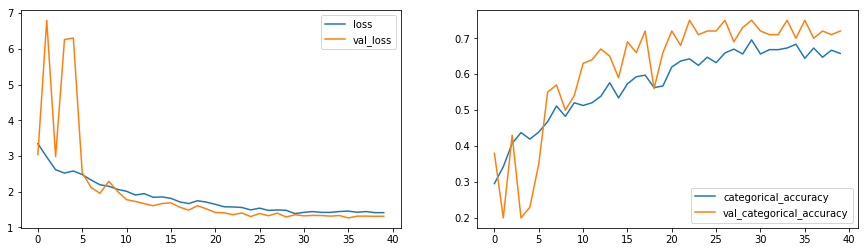

In [23]:
# clear the previous session before poceeding with the new model.
ModelTrainer.clear_previous_keras_session()

# build the model
conv3d_5 = ModelBuilder.conv3d_l2_regularizer_model_5(input_shape, nb_classes)

# train the model
model_history_conv3d_5 = ModelTrainer.train(conv3d_5, batch_size, num_epochs, train_generator, val_generator)

# plot the model train and validation history - loss and accuracy curves
ModelTrainer.plot_model_history(model_history_conv3d_5)

### Inference - 

#### We got a Validation Accuracy of 75% with the val_loss at 1.26411. There is too much loss of information and the accuracy is not upto the expectation.

#### Keeping the L2 regularizer intact let's now add an extra convolution layer to our next variant.

## Model 9

### Keeping the L2 regularizer let's now add an extra convolution layer

Previous Keras Session Cleared...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 30, 120, 120, 16)  1312      
_________________________________________________________________
activation_1 (Activation)    (None, 30, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 120, 120, 16)  64        
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 30, 120, 120, 16)  6928      
_________________________________________________________________
activation_2 (Activation)    (None, 30, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 30, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 15, 60

Epoch 12/40
67/67 [==============================] - 102s 2s/step - loss: 1.7688 - categorical_accuracy: 0.5513 - val_loss: 1.6753 - val_categorical_accuracy: 0.6000

Epoch 00012: val_loss did not improve from 1.60198
Epoch 13/40
67/67 [==============================] - 102s 2s/step - loss: 1.7107 - categorical_accuracy: 0.6065 - val_loss: 1.7271 - val_categorical_accuracy: 0.6000

Epoch 00013: val_loss did not improve from 1.60198

Epoch 00013: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 14/40
67/67 [==============================] - 103s 2s/step - loss: 1.6933 - categorical_accuracy: 0.6070 - val_loss: 1.5457 - val_categorical_accuracy: 0.6500

Epoch 00014: val_loss improved from 1.60198 to 1.54571, saving model to model_init_2019-09-1712_30_05.369107/final_model.h5
Epoch 15/40
67/67 [==============================] - 102s 2s/step - loss: 1.6549 - categorical_accuracy: 0.6005 - val_loss: 1.5782 - val_categorical_accuracy: 0.6400

Epoch 00015: val_loss did

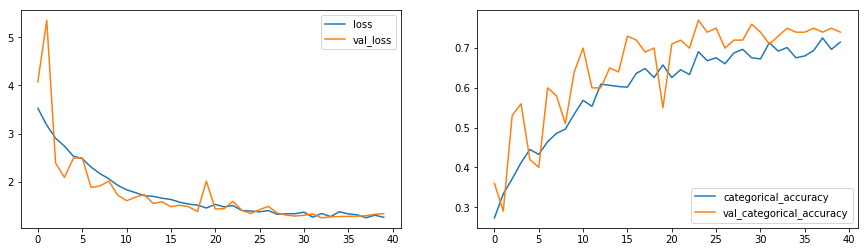

In [19]:
# clear the previous session before poceeding with the new model.
ModelTrainer.clear_previous_keras_session()

# build the model
conv3d_6 = ModelBuilder.conv3d_l2_regularizer_model_6(input_shape, nb_classes)

# train the model
model_history_conv3d_6 = ModelTrainer.train(conv3d_6, batch_size, num_epochs, train_generator, val_generator)

# plot the model train and validation history - loss and accuracy curves
ModelTrainer.plot_model_history(model_history_conv3d_6)

### Inference - 

#### We got a Validation Accuracy of 73% with a corresponding val_loss at 1.24322. There is too much loss of information and the accuracy is not upto the expectation.

#### Now we will modify the structure of the Dense layer so that the flattening of the tensors happens differently

## Model 10

### Adding the 256 and 128 units to the Dense layers

Previous Keras Session Cleared...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 30, 120, 120, 16)  1312      
_________________________________________________________________
activation_1 (Activation)    (None, 30, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 15, 60, 60, 16)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 15, 60, 60, 32)    13856     
_________________________________________________________________
activation_2 (Activation)    (None, 15, 60, 60, 32)    0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 15, 60

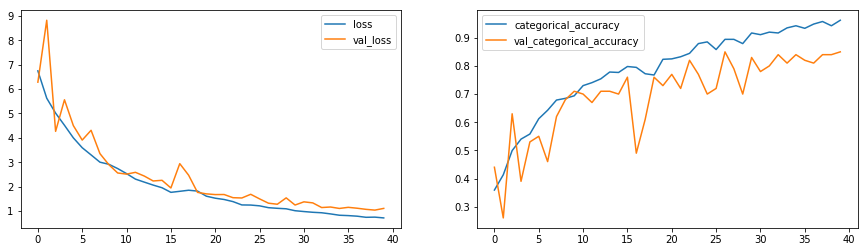

In [20]:
# clear the previous session before poceeding with the new model.
ModelTrainer.clear_previous_keras_session()

# build the model
conv3d_7 = ModelBuilder.conv3d_l2_regularizer_model_7(input_shape, nb_classes)

# train the model
model_history_conv3d_7 = ModelTrainer.train(conv3d_7, batch_size, num_epochs, train_generator, val_generator)

# plot the model train and validation history - loss and accuracy curves
ModelTrainer.plot_model_history(model_history_conv3d_7)

### Inference - 

#### We got a Validation Accuracy of 84% (val_loss at 1.0364) with a training accuracy of 93.98%. The numbers look good as compared to the previous conv3D models and can infer that this model has learnt a lot from the train data.

#### This model turns out to be a good model and now the bench mark score for conv3D model is set as 84%

### <font color='red'>The link to the .h5 file for the final model is provided at the end in the summary section.</font>

#### Let's see if this can be improved further

## Model 11

### Adding more convolution layers


Previous Keras Session Cleared...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 30, 120, 120, 16)  1312      
_________________________________________________________________
activation_1 (Activation)    (None, 30, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 120, 120, 16)  64        
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 30, 120, 120, 16)  6928      
_________________________________________________________________
activation_2 (Activation)    (None, 30, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 30, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 15, 60

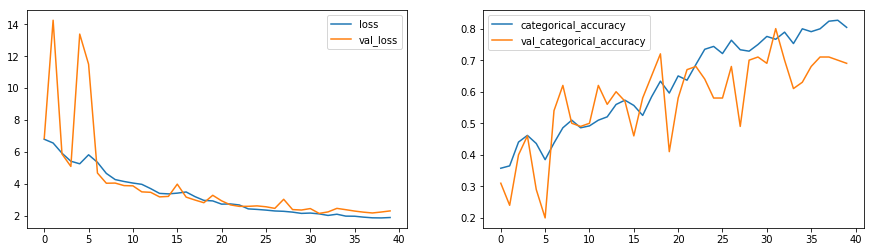

In [21]:
# clear the previous session before poceeding with the new model.
ModelTrainer.clear_previous_keras_session()

# build the model
conv3d_8 = ModelBuilder.conv3d_l2_regularizer_model_8(input_shape, nb_classes)

# train the model
model_history_conv3d_8 = ModelTrainer.train(conv3d_8, batch_size, num_epochs, train_generator, val_generator)

# plot the model train and validation history - loss and accuracy curves
ModelTrainer.plot_model_history(model_history_conv3d_8)

### Inference - 

#### This model does not perform as good as the previous one. We get the validation accuracy of 80%. 

#### So setting the validation accuracy of 84% for Convulation3D model let's try some pre-built models using Transfer Learning and see the if we can achieve a validation accuracy on the higher side of 85%.

# Transfer Learning

## Model 12

### Transfer Learning Model using MobileNet with LSTM layers

Previous Keras Session Cleared...
17227776/17225924 [==============================] - 1s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 30, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_2 (TimeDist (None, 30, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_3 (TimeDist (None, 30, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 30, 1024)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                278784    
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
___________________________________________

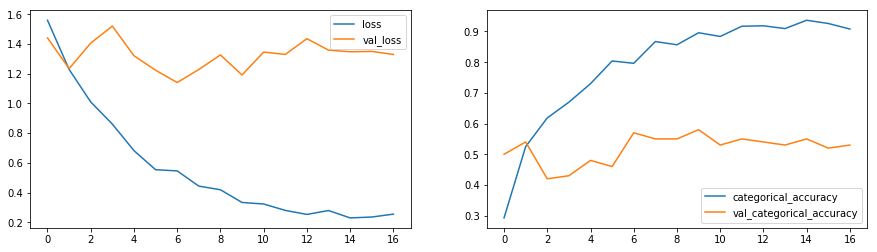

In [20]:
# clear the previous session before poceeding with the new model.
ModelTrainer.clear_previous_keras_session()

# build the model
transfer_learn_imagenet_model_LSTM = ModelBuilder.ImageNet_Transfer_Learn_Model_LSTM(input_shape, nb_classes)

# train the model
model_history_TL_LSTM = ModelTrainer.train(transfer_learn_imagenet_model_LSTM, batch_size, num_epochs, 
                                                                 train_generator, val_generator)

# plot the model train and validation history - loss and accuracy curves
ModelTrainer.plot_model_history(model_history_TL_LSTM)

### Inference - 

#### We got a Validation Accuracy of 57%. This turns out to be a bad model. Let's try to create more models

## Model 13

### Transfer Learning Model using MobileNet with GRU layers. 

### Layers of MobileNet model being trainable.

Previous Keras Session Cleared...
17227776/17225924 [==============================] - 2s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 30, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_2 (TimeDist (None, 30, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_3 (TimeDist (None, 30, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 30, 1024)          0         
_________________________________________________________________
gru_1 (GRU)                  (None, 64)                209088    
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
___________________________________________

67/67 [==============================] - 91s 1s/step - loss: 0.0373 - categorical_accuracy: 0.9896 - val_loss: 0.0928 - val_categorical_accuracy: 0.9500

Epoch 00025: val_loss improved from 0.10050 to 0.09280, saving model to model_init_2019-09-1917_34_50.957975/final_model.h5
Epoch 26/40
67/67 [==============================] - 92s 1s/step - loss: 0.0303 - categorical_accuracy: 0.9925 - val_loss: 0.0925 - val_categorical_accuracy: 0.9500

Epoch 00026: val_loss improved from 0.09280 to 0.09250, saving model to model_init_2019-09-1917_34_50.957975/final_model.h5
Epoch 27/40
67/67 [==============================] - 92s 1s/step - loss: 0.0209 - categorical_accuracy: 1.0000 - val_loss: 0.0912 - val_categorical_accuracy: 0.9500

Epoch 00027: val_loss improved from 0.09250 to 0.09123, saving model to model_init_2019-09-1917_34_50.957975/final_model.h5
Epoch 28/40
67/67 [==============================] - 92s 1s/step - loss: 0.0204 - categorical_accuracy: 0.9985 - val_loss: 0.0958 - val_catego

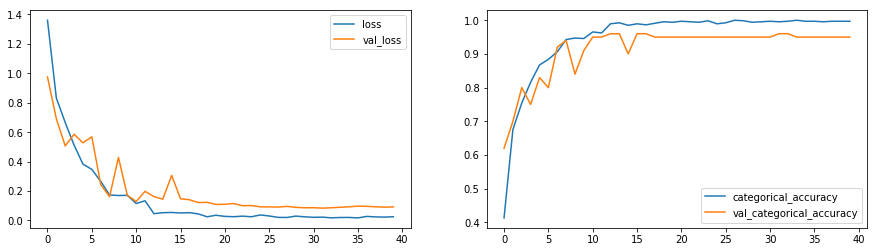

In [22]:
# clear the previous session before poceeding with the new model.
ModelTrainer.clear_previous_keras_session()

# build the model
transfer_learn_imagenet_model_GRU = ModelBuilder.ImageNet_Transfer_Learn_Model_GRU(input_shape, nb_classes)

# train the model
model_history_TL_GRU = ModelTrainer.train(transfer_learn_imagenet_model_GRU, batch_size, num_epochs, 
                                                                 train_generator, val_generator)

# plot the model train and validation history - loss and accuracy curves
ModelTrainer.plot_model_history(model_history_TL_GRU)

### Inference - 

#### The Validation Accuracy is 96% when Traing Accuracy is 99.7%. This is a major improvement considering the Transfer Learning Model.

#### Let's try with the InceptionResnetV2 model.

## Model 14

### Transfer Learning Model using InceptionResNetV2 with GRU layers

### Layers of InceptionResNetV2 model being trainable.

Previous Keras Session Cleared...
219062272/219055592 [==============================] - 8s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, None, 1536)        54336736  
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 1536)        0         
_________________________________________________________________
gru_1 (GRU)                  (None, 256)               1377024   
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 1285      
Total params: 55,715,045
Trainable params: 55,654,501
Non-trainable params: 60,544
_________________________________________________________________
None
Epoch 1/40
Source path =  /kaggle/input/gesture_recognition/Project_data/val ; batch size = 10
Source path =  /kaggle/input/gesture_recognition/Project

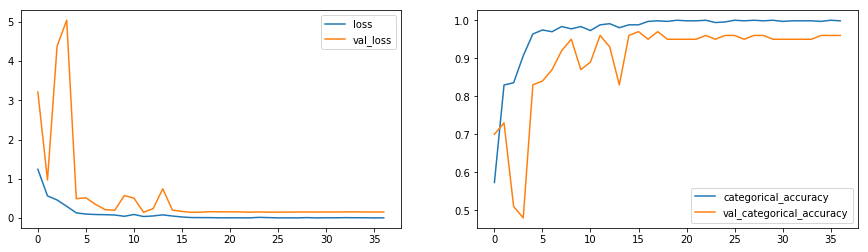

In [20]:
# clear the previous session before poceeding with the new model.
ModelTrainer.clear_previous_keras_session()

l_input_shape = (120, 120, 3)

# build the model
transfer_learn_InceptionResNetV2_model = ModelBuilder.InceptionResNetV2_Transfer_Learn_Model(l_input_shape, nb_classes)

# train the model
model_history_transfer_learn_InceptionResNetV2_model = ModelTrainer.train(transfer_learn_InceptionResNetV2_model, batch_size, 
                                                                          num_epochs, train_generator, val_generator)

# plot the model train and validation history - loss and accuracy curves
ModelTrainer.plot_model_history(model_history_transfer_learn_InceptionResNetV2_model)

### Inference - 

#### We got a Validation Accuracy as a mere 95% when Training accuracy is 99.7%. This turns out to be a very good classifier model.

#### Lets try with the EfficientNetB0 pre-trained model.

## Model 15

### Transfer Learning Model using EfficientNetB0 with GRU layers

### Layers of EfficientNetB0 being trainable

Previous Keras Session Cleared...
16719872/16717576 [==============================] - 1s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, None, 1280)        4049564   
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 1280)        0         
_________________________________________________________________
gru_1 (GRU)                  (None, 256)               1180416   
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 1285      
Total params: 5,231,265
Trainable params: 5,189,249
Non-trainable params: 42,016
_________________________________________________________________
None
Epoch 1/40
67/67 [==============================] - 178s 3s/step - loss: 0.8245 - categorical_accuracy: 0.6995 - val_loss: 0.5907 - val_categorical_accurac

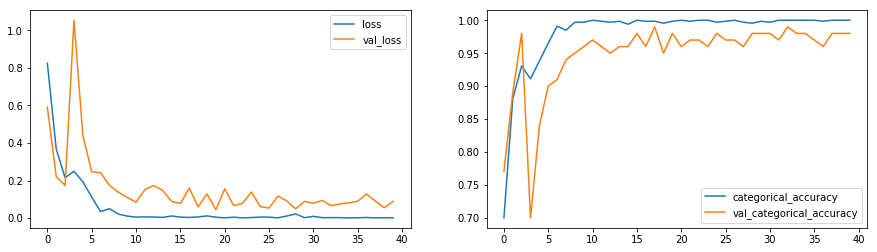

In [21]:
# clear the previous session before poceeding with the new model.
ModelTrainer.clear_previous_keras_session()

l_input_shape = (120, 120, 3)

# build the model
transfer_learn_EfficientNetB0_model = ModelBuilder.EfficientNetB0_Transfer_Learn_Model(l_input_shape, nb_classes)

# train the model
model_history_transfer_learn_EfficientNetB0_model = ModelTrainer.train(transfer_learn_EfficientNetB0_model, batch_size, 
                                                                          num_epochs, train_generator, val_generator)

# plot the model train and validation history - loss and accuracy curves
ModelTrainer.plot_model_history(model_history_transfer_learn_EfficientNetB0_model)

### Inference - 

#### We got a Validation Accuracy of 98% while the Training Accuracy is 99.85% with Validation loss od 0.044. This is the best model we got using Transfer Learning. 

### <font color='red'>The link to the .h5 file for the final model is provided at the end in the summary section.</font>

# Summary

**In this Project, We experimented on 3 diffent types of methods:**

1. CNN (Conv2D) + RNN
2. CNN (Conv3D)
3. CNN (Transfer Learning) + RNN

#### 1. CNN (CONV2D) + RNN

- Model 3 is the best model in terms of CNN(CONV2D) + RNN. It got a validation accuracy of 84% consistently without overfitting the training data and has a training accuracy between 90-94%.

#### Link to the .h5 file for model 3 -  <a href="https://drive.google.com/open?id=1C-tdDLhXJG2b6Kc9RL3zHWkaGReMil4Y"> https://drive.google.com/open?id=1C-tdDLhXJG2b6Kc9RL3zHWkaGReMil4Y</a>

#### 2. Conv3D

- Model 10 is the best model in terms of CNN(Conv3D) + RNN. It got a validation accuracy of 84% consistently without overfitting the training data and has a training accuracy between 90-95%.

#### Link to the .h5 file for model 10 - <a href="https://drive.google.com/open?id=1Lz51tUaxvPV3m9dZUPt9Z9mmtShrVZB_">https://drive.google.com/open?id=1Lz51tUaxvPV3m9dZUPt9Z9mmtShrVZB_</a>

#### 3. CNN (Transfer Learning) + RNN

- Model 15 is the best model in terms of CNN(Transfer Learning) + RNN. It got a validation accuracy of 98% consistently without overfitting the training data and has a training accuracy between 98-99%.

#### Link to the .h5 file for model 15 - <a href="https://drive.google.com/open?id=192mnQR2p-H-KZpEfpKbSq6VPP0Koevvh">https://drive.google.com/open?id=192mnQR2p-H-KZpEfpKbSq6VPP0Koevvh</a>

# Final Verdict

From the summary above we see that our transfer learning model built using EfficientNetB0 pre-trained model achieves the best validation accuracy of 98% without overfitting on the training data. The training accuracy stands at 99.85% with a very minimal loss of information.

**Thus, we choose Model 15 as the best model for the task of gesture recognition.**